In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.special import gammaincinv
from astropy.modeling.functional_models import Sersic2D
from astropy.visualization import simple_norm

In [2]:
plt.rcParams.update({
    'text.usetex': False,
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.family': 'serif',
    'font.weight': 'normal',
    'figure.facecolor': 'lightgray',
    'mathtext.fontset': 'dejavuserif'
})

### c) Graficar el perfil radial para índices 0.5, 1, 2, 4, y 6.

- Usar $I_e$ y $r_e$ como unidades


$$I(r) = I_e \exp\bigg\{-b_n\left[\left(\frac{r}{r_e}\right)^{1/n}-1\right]\bigg\}$$

para unidades $r_e$:  $$R = \frac{r}{r_e}$$ 

para unidades $I_e$: $$I(R) \equiv \frac{I(r)}{I_e} = \exp\bigg\{-b_n\left[R^{1/n}-1\right]\bigg\}$$

In [3]:
def calculate_b_coefficients(n):
    return gammaincinv(2.0 * n, 0.5)

def radial_profile(r_array, n):
    b = calculate_b_coefficients(n)
    return np.exp(-b * (r_array ** (1/n) - 1))

In [4]:
radial_array = np.linspace(0.1, 3.2, 500)

In [5]:
radial_profile_0_5 = radial_profile(radial_array, 0.5)
radial_profile_1 = radial_profile(radial_array, 1)
radial_profile_2 = radial_profile(radial_array, 2)
radial_profile_4 = radial_profile(radial_array, 4)
radial_profile_6 = radial_profile(radial_array, 6)

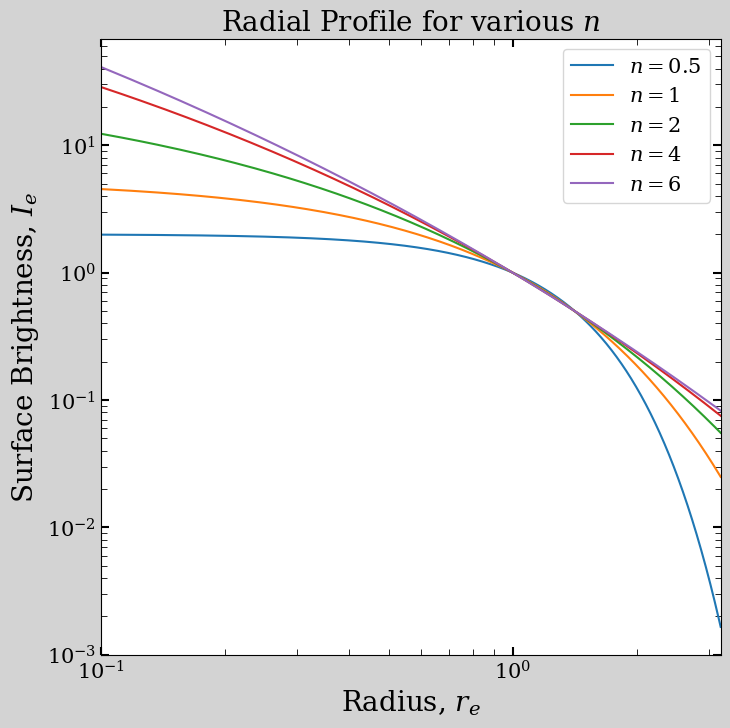

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(radial_array, radial_profile_0_5, label=r'$n=0.5$')
ax.plot(radial_array, radial_profile_1, label=r'$n=1$')
ax.plot(radial_array, radial_profile_2, label=r'$n=2$')
ax.plot(radial_array, radial_profile_4, label=r'$n=4$')
ax.plot(radial_array, radial_profile_6, label=r'$n=6$')


ax.set_ylabel(r'Surface Brightness, $I_{e}$', fontsize=20)
ax.set_xlabel(r"Radius, $r_e$", fontsize=20)
ax.set_title(r'Radial Profile for various $n$', fontsize=20)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.1, 3.2)

ax.tick_params(axis='both', labelsize=15, direction='in', right=True, top=True,
                length=6, width=1.5, grid_color='black', grid_alpha=1, grid_linestyle="-",
                grid_linewidth=0.5)

ax.tick_params(which='minor', length=4, color='black', direction='in', top=True, right=True,
                grid_alpha=0.2, grid_linewidth=0.5, grid_linestyle="-",grid_color='r')


ax.grid(False, which='both')
ax.legend(fontsize=15, markerscale=1)

Notamos que a medida que los $n$ aumentan, el brillo superficial decae más lento a medida que nos alejamos del centro del perfil.

### d) Usar Sersic2D de astropy para generar imagenes de perfiles de sersic variando I_e, r_e y n

In [69]:
def calculate_sersic_profile(intensity, effective_radius, n, center_x=100, center_y=100, ellipticity=0.5, angle=0):
    
    # creamos una malla de coordenadas x e y, con un tamaño de 200x200
    x_coords, y_coords = np.meshgrid(np.arange(200), np.arange(200))
    
    # definimos el perfil de Sersic2D
    sersic_model = Sersic2D(
        amplitude=intensity,
        r_eff=effective_radius,
        n=n,
        x_0=center_x,
        y_0=center_y,
        ellip=ellipticity,
        theta=angle
    )
    sersic_image = sersic_model(x_coords, y_coords)
    
    # calculamos la intensidad total sumando todos los pixeles
    total_intensity = sersic_image.sum()
    
    # calculamos los radios desde el centro de los perfiles
    radii = np.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)
    
    # ordenamos los radios
    flattened_indices = np.argsort(radii, axis=None)
    # obtenemos un array 1d de radios con ravel()
    sorted_radii = radii.ravel()[flattened_indices]
    # obtenemos un array 1d de intensidades con ravel()
    sorted_intensities = sersic_image.ravel()[flattened_indices]
    
    # calculamos la intensidad acumulada
    cumulative_intensity = np.cumsum(sorted_intensities)
    
    # buscamos el índice del radio que contiene el 90% de la intensidad total
    ninety_percent_index = np.searchsorted(cumulative_intensity, 0.9 * total_intensity)
    radius_90 = sorted_radii[ninety_percent_index]

    # graficamos
    fig, ax = plt.subplots()
    im = ax.imshow(sersic_image, origin='lower', interpolation='nearest', vmin=-1, vmax=2, cmap='magma')
    colorbar = fig.colorbar(im, ax=ax)
    colorbar.set_label('Brightness', rotation=270, labelpad=25)
    colorbar.set_ticks([-1, 0, 1, 2])

    # añadimos un círculo indicando el radio del 90%
    circle = plt.Circle((center_x, center_y), radius_90, color='red', fill=False, label=f'R_90 = {radius_90:.2f}')
    
    # agregamos textos con los valores de n, Ie y re
    ax.text(0.05, 0.95, f'n = {n}', transform=ax.transAxes, fontsize=15, verticalalignment='top', color='white')
    ax.text(0.05, 0.85, f'Ie = {intensity}', transform=ax.transAxes, fontsize=15, verticalalignment='top', color='white')
    ax.text(0.05, 0.75, f're = {effective_radius}', transform=ax.transAxes, fontsize=15, verticalalignment='top', color='white')

    ax.add_artist(circle)
    ax.legend()
    
    plt.show()

    return

In [71]:
# Definimos los valores de n, Ie y re que vamos a plotear

Ie_values = [1, 5, 10]
re_values = [10, 20, 30]
n_values = [1, 2, 4]

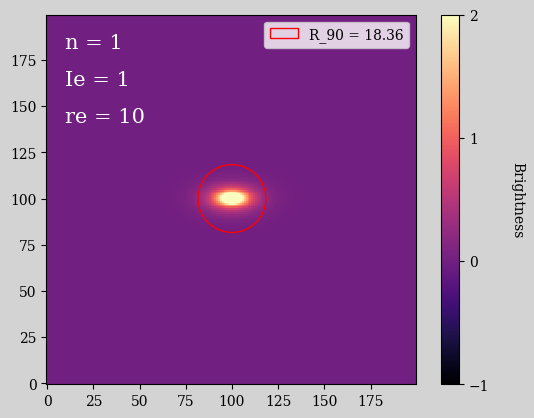

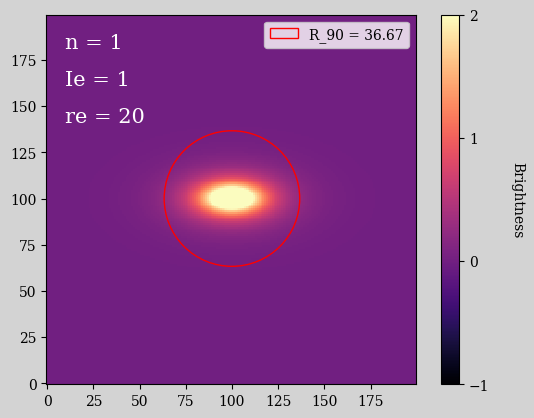

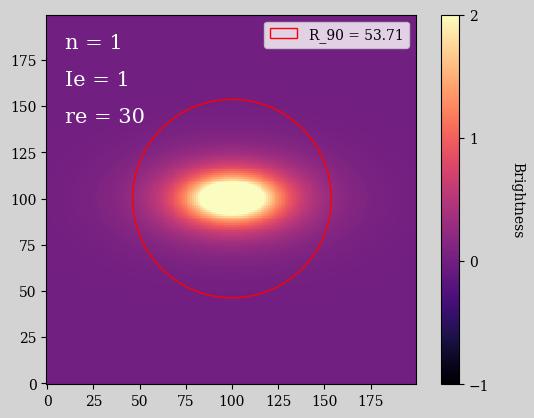

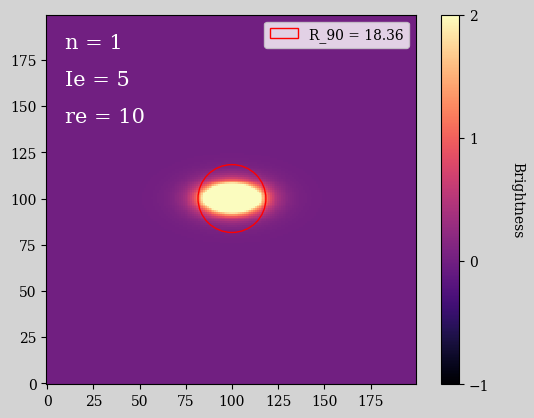

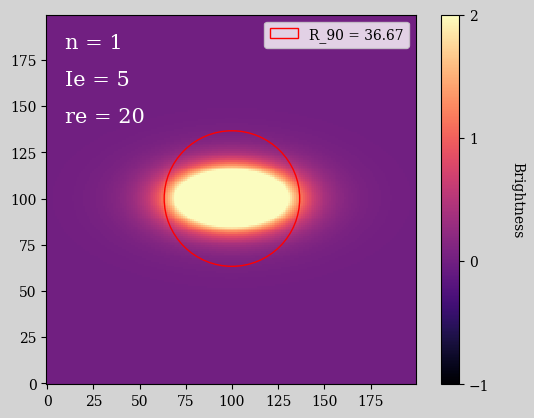

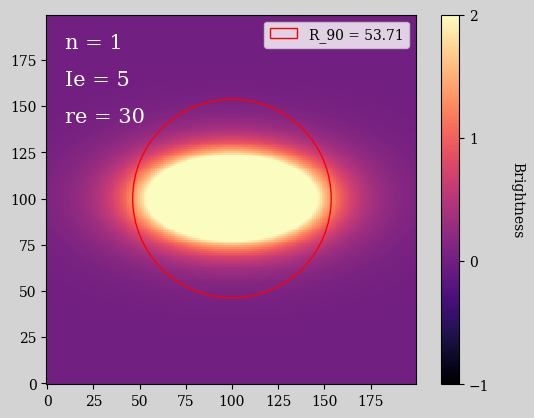

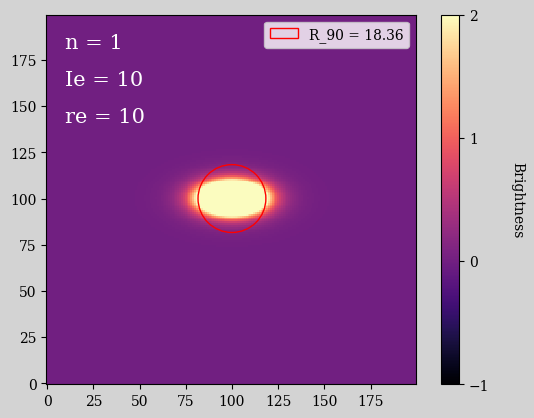

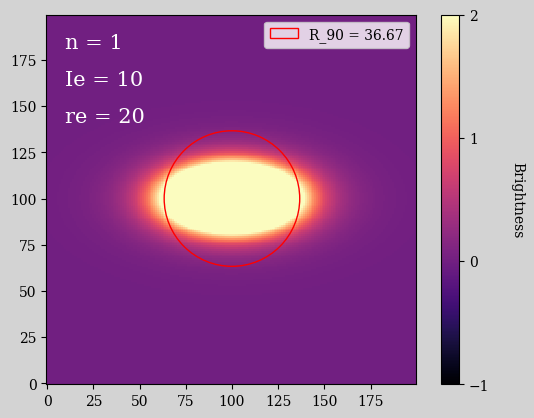

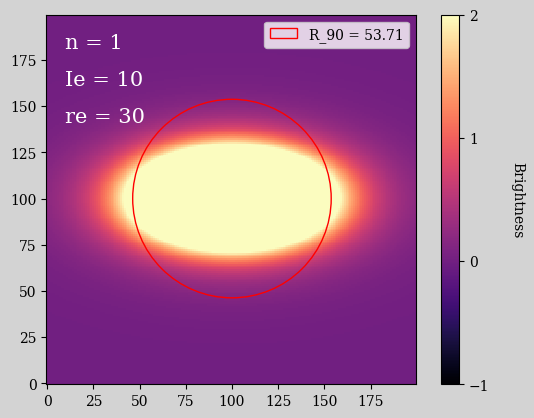

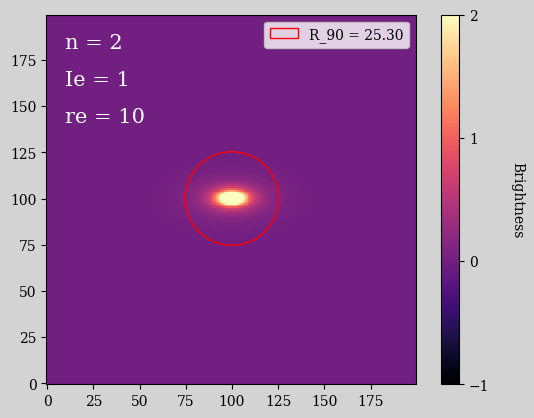

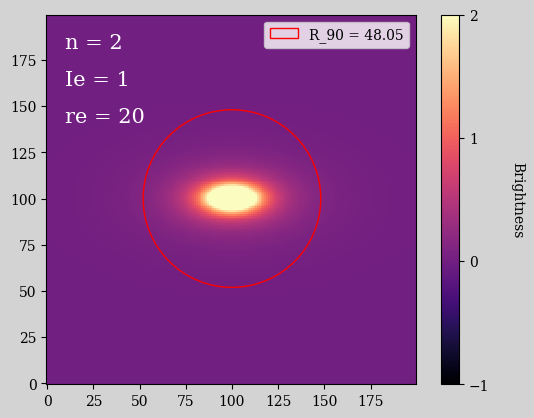

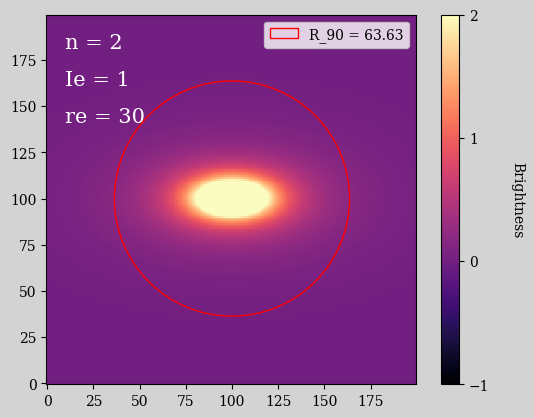

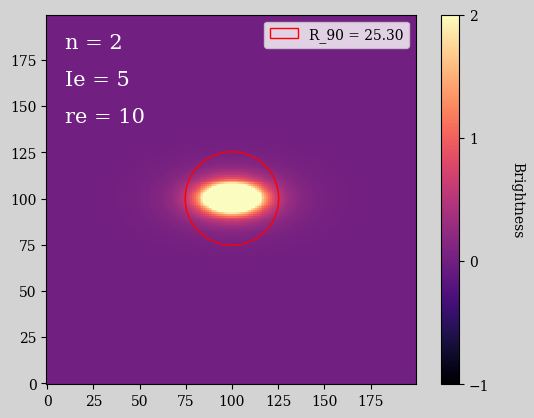

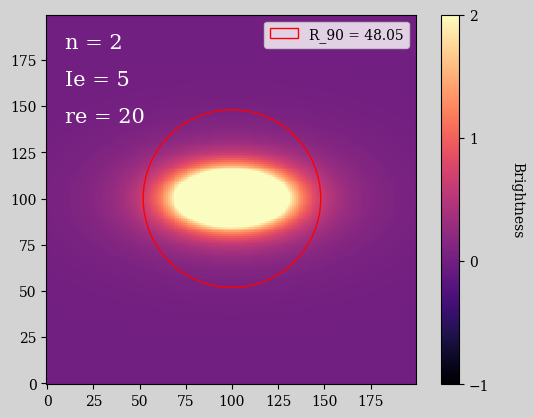

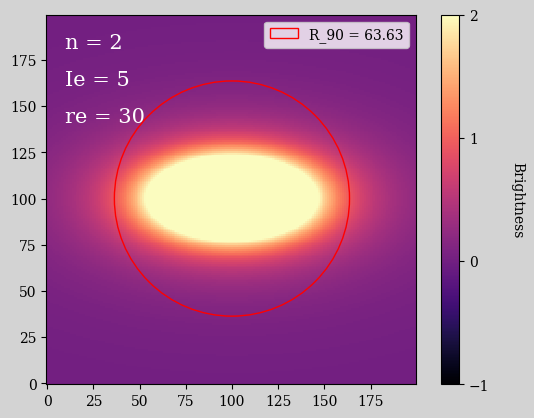

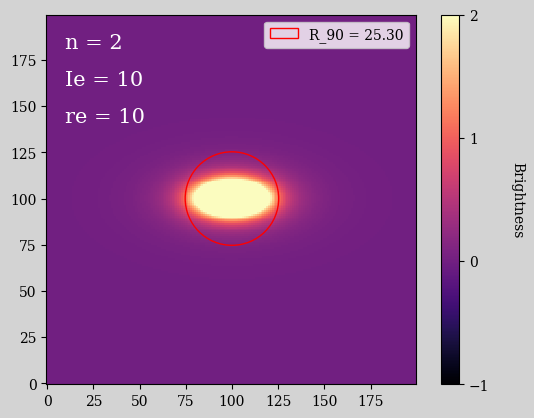

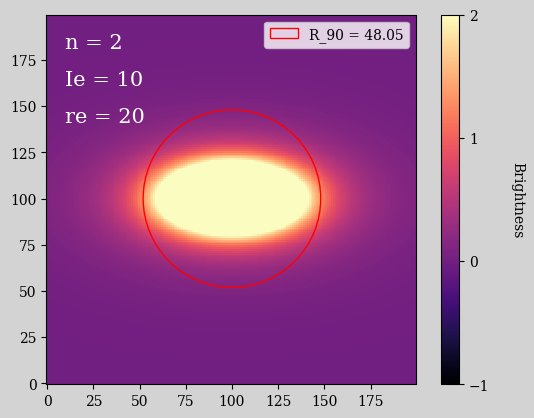

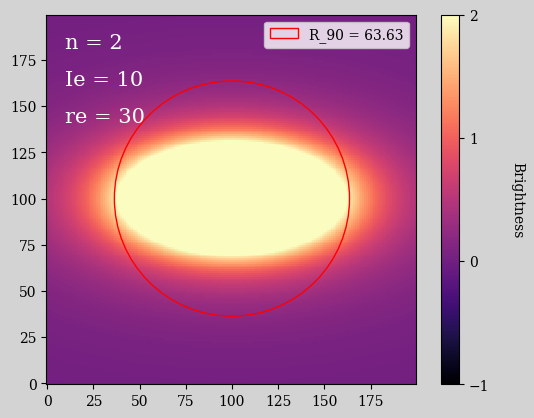

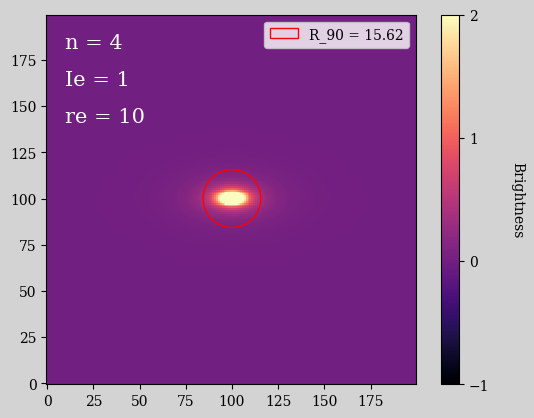

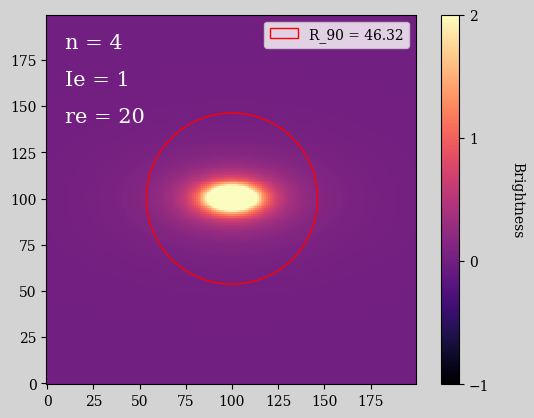

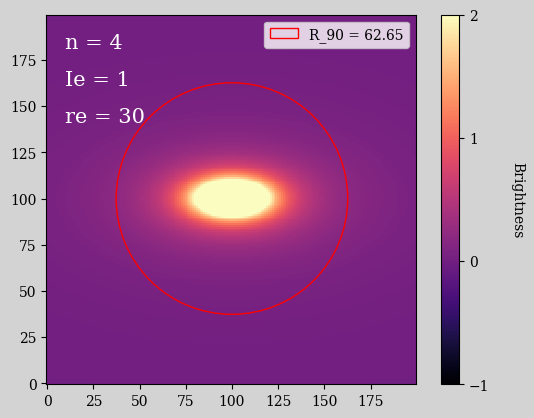

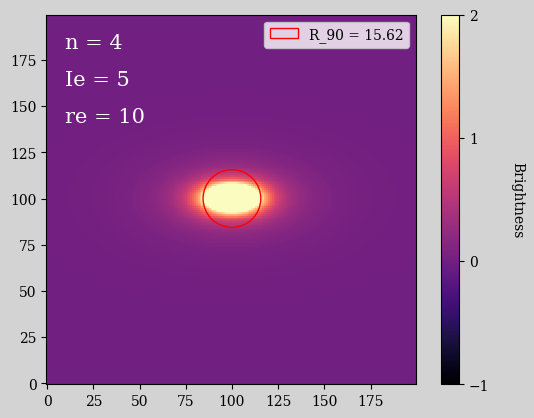

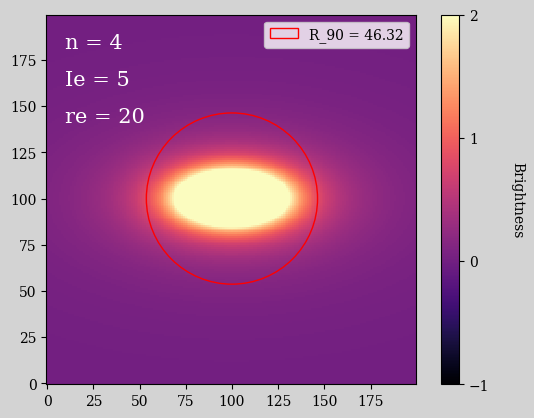

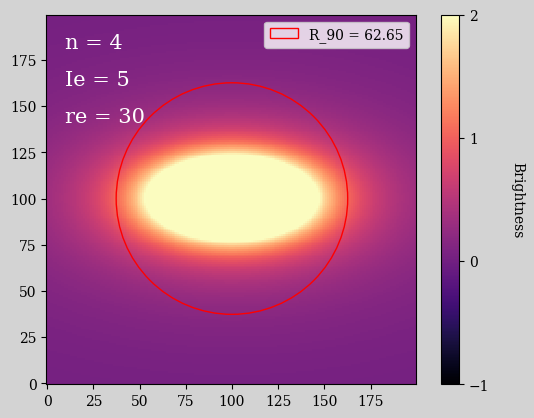

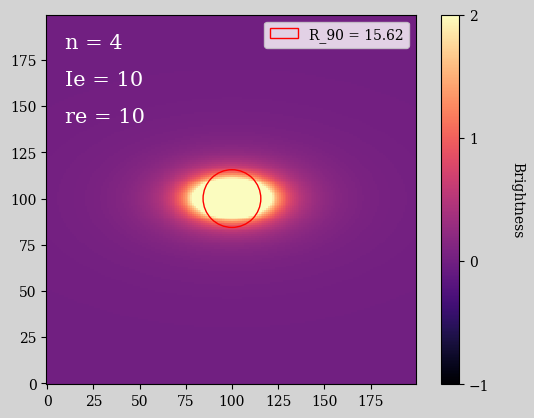

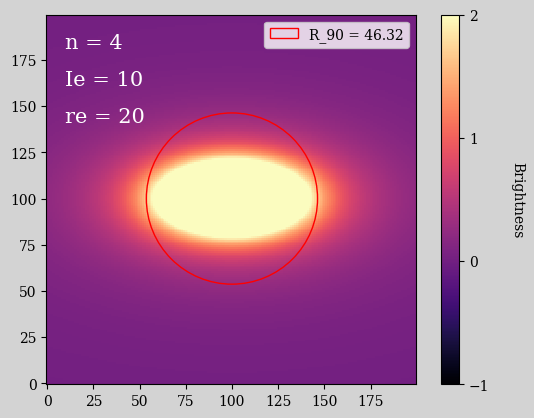

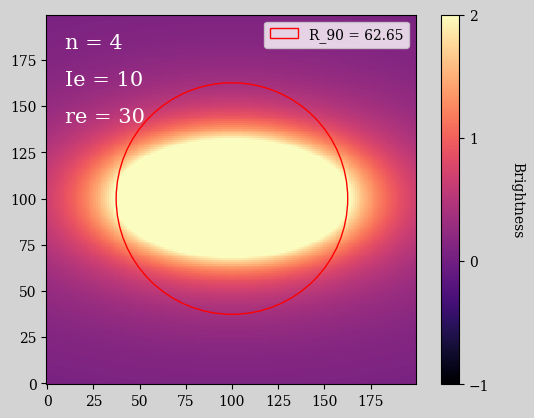

In [72]:
# Iteramos sobre todos los valores de n, Ie y re

for n in n_values:
    for Ie in Ie_values:
        for re in re_values:
            calculate_sersic_profile(
                intensity=Ie,
                effective_radius=re,
                n=n
            )